In [3]:
import os
import cv2
import pickle

In [4]:
folder = 'images'
path = os.path.join(folder, '{}.pkl'.format('pos'))
with open(path, 'rb') as f:
    pos_data = pickle.load(f)

path = os.path.join(folder, '{}.pkl'.format('neg'))
with open(path, 'rb') as f:
    neg_data = pickle.load(f)

print(len(pos_data))
print(len(neg_data))

5898
6664


In [16]:
from matplotlib.colors import rgb_to_hsv

def rgb_2_hsv(data):
    new_data = []
    for pdata, cdata, pflow, cflow in data:
        pdata = cv2.cvtColor(pdata, cv2.COLOR_RGB2HSV)
        cdata = cv2.cvtColor(cdata, cv2.COLOR_RGB2HSV)
#         pdata = rgb_to_hsv(pdata)
#         cdata = rgb_to_hsv(cdata)
        new_data.append([pdata, cdata, pflow, cflow])
    return new_data

hsv_pos_data = rgb_2_hsv(pos_data)
hsv_neg_data = rgb_2_hsv(neg_data)

print(hsv_pos_data[0][0].dtype)

uint8


In [186]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from skimage import io, transform

In [171]:
class CutEditorDataset(Dataset):
    """Cut editor dataset."""

    def __init__(self, pos_data, neg_data, transform=None):
        pos_data_nor = [((pdata.astype(np.float32), cdata.astype(np.float32), pflow.astype(np.float32), cflow.astype(np.float32)), 1.0) for
                        (pdata, cdata, pflow, cflow) in pos_data]
        pos_data_rev = [((cdata.astype(np.float32), pdata.astype(np.float32), -cflow.astype(np.float32), -pflow.astype(np.float32)), 1.0) for
                        (pdata, cdata, pflow, cflow) in pos_data]
        neg_data_nor = [((pdata.astype(np.float32), cdata.astype(np.float32), pflow.astype(np.float32), cflow.astype(np.float32)), 0.0) for
                        (pdata, cdata, pflow, cflow) in neg_data]
        neg_data_rev = [((cdata.astype(np.float32), pdata.astype(np.float32), -cflow.astype(np.float32), -pflow.astype(np.float32)), 0.0) for
                        (pdata, cdata, pflow, cflow) in neg_data]
        self.data = pos_data_nor + neg_data_nor + pos_data_rev + neg_data_rev
#         self.data = pos_data_nor + neg_data_nor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        pdata, cdata, pflow, cflow = self.data[idx][0]
        mark = self.data[idx][1]
#         sample = {
#             'pdata': pdata.astype(np.float32),
#             'cdata': cdata.astype(np.float32),
#             'pflow': pflow.astype(np.float32),
#             'cflow': cflow.astype(np.float32),
#             'mark': mark
#         }
        if self.transform:
            pdata, cdata, pflow, cflow, mark = self.transform((pdata, cdata, pflow, cflow, mark))
        return pdata, cdata, pflow, cflow, mark


class RandomCrop(object):

    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        pdata, cdata, pflow, cflow, mark = data
#         pdata = sample['pdata']
#         cdata = sample['cdata']
#         pflow = sample['pflow']
#         cflow = sample['cflow']
#         mark = sample['mark']

        h, w = pdata.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        pdata = pdata[top: top + new_h, left: left + new_w]
        cdata = cdata[top: top + new_h, left: left + new_w]
        pflow = pflow[top: top + new_h, left: left + new_w]
        cflow = cflow[top: top + new_h, left: left + new_w]

#         sample = {
#             'pdata': pdata,
#             'cdata': cdata,
#             'pflow': pflow,
#             'cflow': cflow,
#             'mark': mark
#         }

        return pdata, cdata, pflow, cflow, mark


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        pdata, cdata, pflow, cflow, mark = data
#         pdata = sample['pdata']
#         cdata = sample['cdata']
#         pflow = sample['pflow']
#         cflow = sample['cflow']
#         mark = sample['mark']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        pdata = pdata.transpose((2, 0, 1))
        cdata = cdata.transpose((2, 0, 1))
        pflow = pflow.transpose((2, 0, 1))
        cflow = cflow.transpose((2, 0, 1))

#         sample = {
#             'pdata': torch.from_numpy(pdata),
#             'cdata': torch.from_numpy(cdata),
#             'pflow': torch.from_numpy(pflow),
#             'cflow': torch.from_numpy(cflow),
#             'mark': mark
#         }

        return pdata, cdata, pflow, cflow, mark

25124


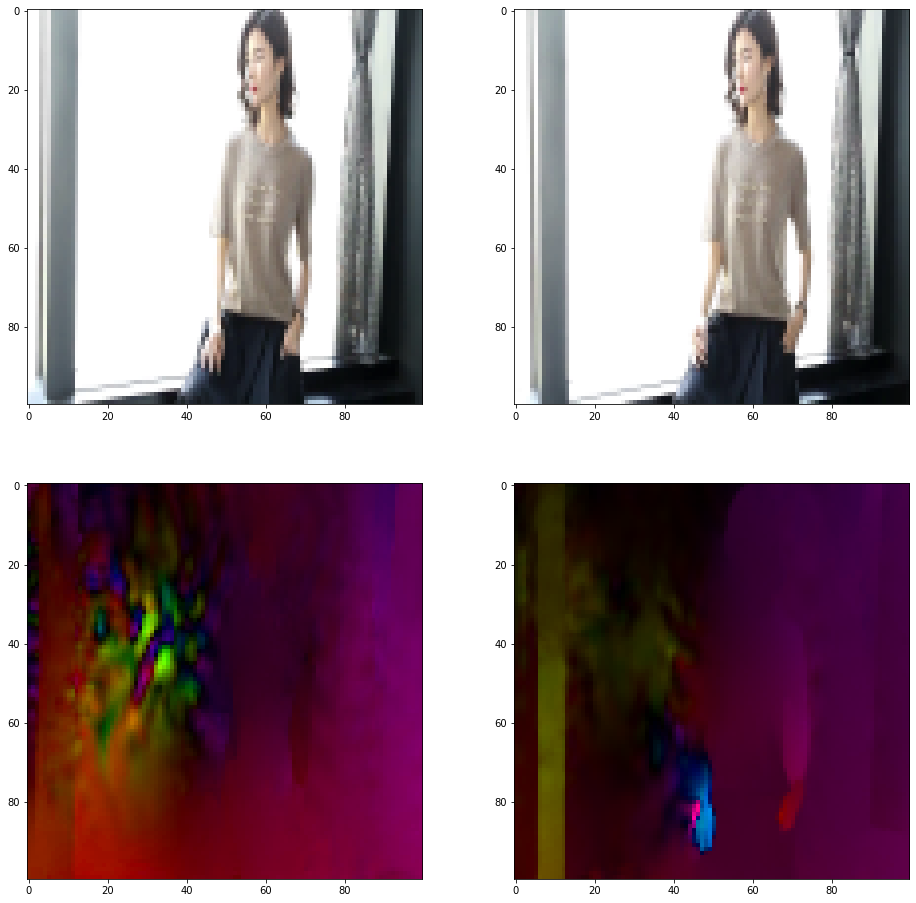

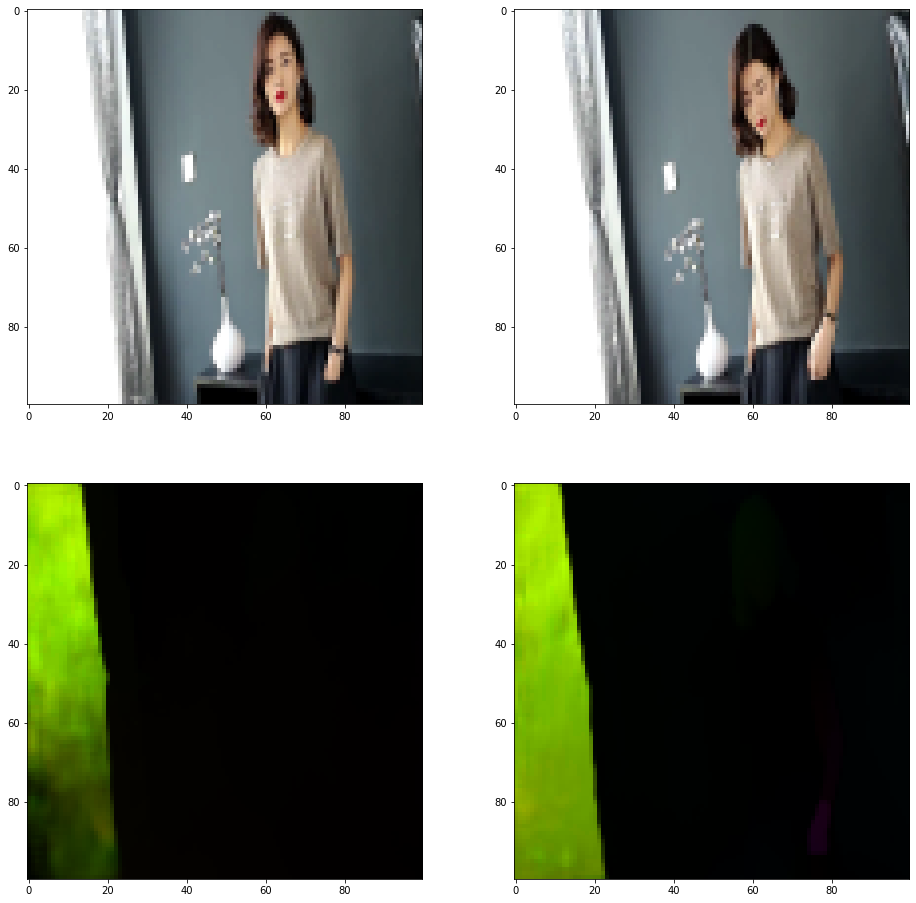

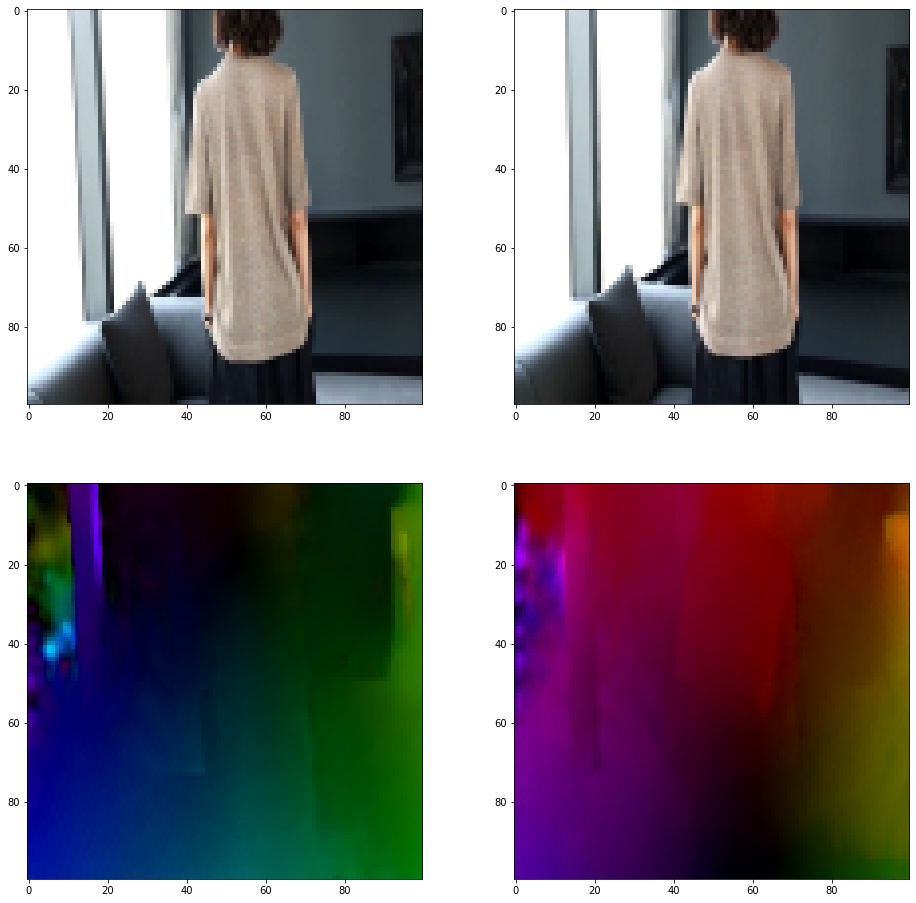

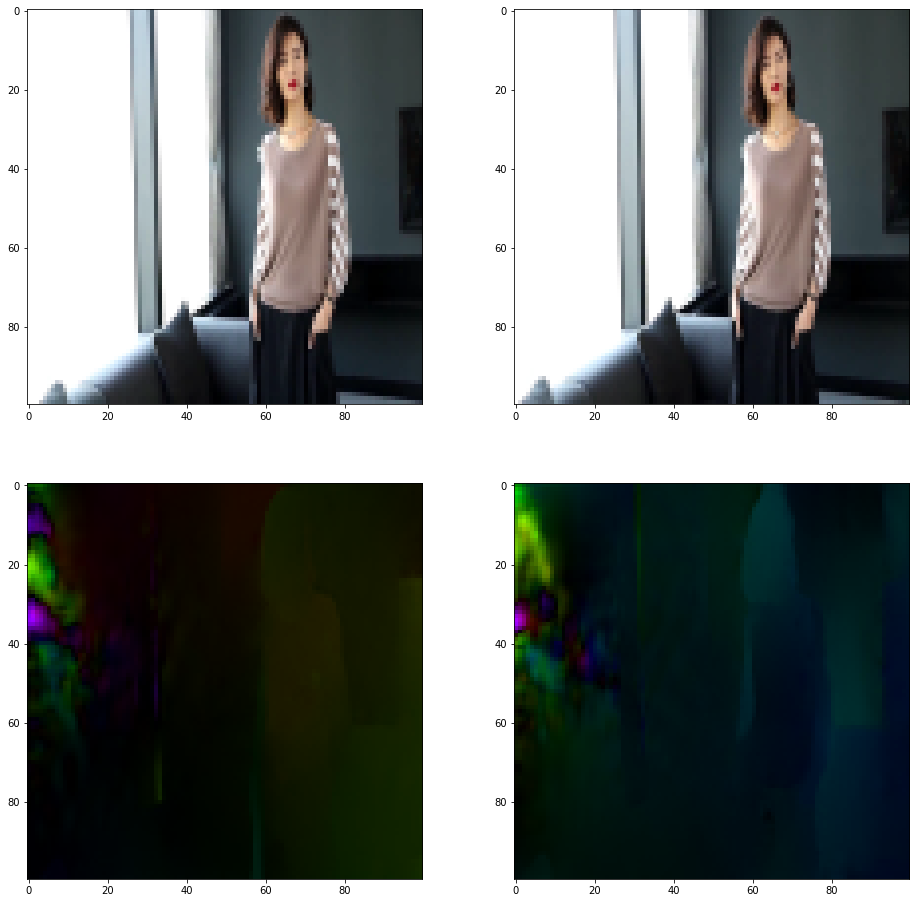

In [172]:
cut_dataset = CutEditorDataset(hsv_pos_data, hsv_neg_data)

def flow_to_image(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    (height, width, _) = flow.shape
    hsv = np.zeros((height, width, 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return bgr

print(len(cut_dataset))

for i in range(8000, len(cut_dataset)):
#     sample = cut_dataset[i]
    pdata, cdata, pflow, cflow, mark = cut_dataset[i]
    plt.figure(figsize=(16, 16))
    ax1 = plt.subplot(2,2,1)
    plt.sca(ax1)
    plt.imshow(cv2.cvtColor(pdata.astype(np.uint8), cv2.COLOR_HSV2RGB))
#     plt.imshow(hsv_to_rgb(sample['pdata']) / 255)
    ax2 = plt.subplot(2,2,2)
    plt.sca(ax2)
    plt.imshow(cv2.cvtColor(cdata.astype(np.uint8), cv2.COLOR_HSV2RGB))
#     plt.imshow(hsv_to_rgb(sample['cdata']) / 255)
    ax3 = plt.subplot(2,2,3)
    plt.sca(ax3)
    plt.imshow(flow_to_image(pflow))
    ax4 = plt.subplot(2,2,4)
    plt.sca(ax4)
    plt.imshow(flow_to_image(cflow))
    plt.show()
    if i == 8003:
        break

In [177]:
tran_cut_dataset = CutEditorDataset(hsv_pos_data, hsv_neg_data,
                                   transform=transforms.Compose([
                                   RandomCrop(76),
                                   ToTensor()
                               ]))

# tran_cut_dataset = CutEditorDataset(hsv_pos_data, hsv_neg_data)

print(len(tran_cut_dataset))

start = time.time()
for i in range(len(tran_cut_dataset)):
#     sample = tran_cut_dataset[i]
    pdata, cdata, pflow, cflow, mark = tran_cut_dataset[i]
#     print(sample['pdata'].dtype)
#     print(sample['cdata'].dtype)
#     print(sample['pflow'].dtype)
#     print(sample['cflow'].dtype)
#     print(sample['mark'])
    print(pdata.dtype)
    print(cdata.dtype)
    print(pflow.dtype)
    print(cflow.dtype)
    print(mark)

    if i == 3:
        break
end = time.time()
print(end - start)

25124
float32
float32
float32
float32
1.0
float32
float32
float32
float32
1.0
float32
float32
float32
float32
1.0
float32
float32
float32
float32
1.0
0.0005521774291992188


In [178]:
# %env JOBLIB_TEMP_FOLDER=/tmp

dataloader = DataLoader(tran_cut_dataset, batch_size=256,
                        shuffle=True)

start = time.time()
for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch, sample_batched['pdata'].dtype,
#           sample_batched['mark'].dtype)
    pdata, cdata, pflow, cflow, mark = sample_batched
    print(i_batch, pdata.shape, mark.dtype)
    if i_batch == 10:
        break
end = time.time()
print(end - start)

0 torch.Size([256, 3, 76, 76]) torch.float64
1 torch.Size([256, 3, 76, 76]) torch.float64
2 torch.Size([256, 3, 76, 76]) torch.float64
3 torch.Size([256, 3, 76, 76]) torch.float64
4 torch.Size([256, 3, 76, 76]) torch.float64
5 torch.Size([256, 3, 76, 76]) torch.float64
6 torch.Size([256, 3, 76, 76]) torch.float64
7 torch.Size([256, 3, 76, 76]) torch.float64
8 torch.Size([256, 3, 76, 76]) torch.float64
9 torch.Size([256, 3, 76, 76]) torch.float64
10 torch.Size([256, 3, 76, 76]) torch.float64
0.2471909523010254


In [179]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class BranchNet(nn.Module):

    def __init__(self):
        super(BranchNet, self).__init__()
        self.conv1_1 = nn.Conv2d(5, 6, 5)
        self.conv2_1 = nn.Conv2d(5, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1_2 = nn.Conv2d(6, 16, 5)
        self.conv2_2 = nn.Conv2d(6, 16, 5)
        self.conv1_3 = nn.Conv2d(16, 32, 3)
        self.conv2_3 = nn.Conv2d(16, 32, 3)
#         self.fc1 = nn.Linear(2 * 16 * 16 * 16, 120)
        self.fc1 = nn.Linear(2 * 7 * 7 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x1, x2, x3, x4):
        # prev branch
        x1 = torch.cat((x1, x3), 1)
        x1 = self.pool(F.relu(self.conv1_1(x1)))
        x1 = self.pool(F.relu(self.conv1_2(x1)))
        x1 = self.pool(F.relu(self.conv1_3(x1)))
#         x1 = x1.view(-1, 7 * 7 * 32)
        x1 = torch.flatten(x1, start_dim=1)
#         x1 = x1.view(-1, 16 * 16 * 16)
        # curr branch
        x2 = torch.cat((x2, x4), 1)
        x2 = self.pool(F.relu(self.conv2_1(x2)))
        x2 = self.pool(F.relu(self.conv2_2(x2)))
        x2 = self.pool(F.relu(self.conv2_3(x2)))
        x2 = torch.flatten(x2, start_dim=1)
#         x2 = x2.view(-1, 7 * 7 * 32)
#         x2 = x2.view(-1, 16 * 16 * 16)
        # concat FC
        x = torch.cat((x1, x2), 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [180]:
class ConcatNet(nn.Module):

    def __init__(self):
        super(ConcatNet, self).__init__()
        self.conv1 = nn.Conv2d(10, 12, 5)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
#         self.fc1 = nn.Linear(16 * 16 * 16, 120)
        self.fc1 = nn.Linear(7 * 7 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x1, x2, x3, x4):
        x = torch.cat((x1, x2, x3, x4), 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 16 * 16 * 16)
#         x = x.view(-1, 7 * 7 * 32)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
     # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [241]:
import torch.optim as optim
import time

net = ConcatNet()
# net = BranchNet()
net.apply(weight_init)
net.train()

gpus = [0]
torch.cuda.set_device('cuda:{}'.format(gpus[0]))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(2000):
    running_loss = 0.0
    correct = 0
    start = time.time()
    for i, batch in enumerate(dataloader):
        pdata, cdata, pflow, cflow, mark = batch
#         pdata = batch['pdata'].to(device)
#         cdata = batch['cdata'].to(device)
#         pflow = batch['pflow'].to(device)
#         cflow = batch['cflow'].to(device)
#         mark = torch.reshape(batch['mark'], (-1, 1)).to(device)
        pdata = pdata.to(device)
        cdata = cdata.to(device)
        pflow = pflow.to(device)
        cflow = cflow.to(device)
        mark = torch.reshape(mark, (-1, 1)).to(device)
        outputs = net(pdata, cdata, pflow, cflow)
        optimizer.zero_grad()
        loss = criterion(outputs, mark)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        
        results = torch.sigmoid(outputs)
        ones = torch.ones(results.shape).to(device)
        zeros = torch.zeros(results.shape).to(device)
        results = torch.where(results >= 0.5, ones, zeros)
        res = torch.sum(results == mark).item()
        correct += res

#         if i % 500 == 499:
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 499))
#             running_loss = 0.0
    end = time.time()
    running_loss /= len(dataloader)
    acc = 100 * correct / len(tran_cut_dataset)
    print('[%d] loss: %.3f, acc: %.3f, cost %.3f' % (epoch + 1, running_loss, acc, end - start))

cuda:0
[1] loss: 4.584, acc: 46.601, cost 4.126


KeyboardInterrupt: 

In [ ]:
x3d = torch.randn(4, 5, 2, 100, 100)
conv3d = nn.Conv3d(5, 16, kernel_size=(2, 3, 3), stride=1, padding=0)
print(conv3d.weight.size())
out3d = conv3d(x3d)
print(out3d.size())
x2d = torch.randn(4, 10, 100, 100)
conv2d = nn.Conv2d(10, 16, 3)
print(conv2d.weight.size())
out2d = conv2d(x2d)
print(out2d.size())

In [ ]:
x = torch.randn(4, 3, 100, 100)
y = torch.randn(4, 2, 100, 100)
z = torch.cat((x, y), 1).view(-1, )
torch.cat(z, z).shape

In [ ]:
x = torch.Tensor([1, 0, 1, 1])
x - x

In [ ]:
x.view(-1, 1)

In [47]:
x = torch.randn(1280000, 7, 7, 32)
x.shape

torch.Size([1280000, 7, 7, 32])

In [116]:
%%time
torch.flatten(x, start_dim=1).shape

CPU times: user 482 µs, sys: 366 µs, total: 848 µs
Wall time: 571 µs


torch.Size([2560, 1568])

In [117]:
%%time
torch.reshape(x, (-1, 7 * 7 * 32)).shape

CPU times: user 39 µs, sys: 29 µs, total: 68 µs
Wall time: 73.9 µs


torch.Size([2560, 1568])

In [113]:
%%time
x.view(-1, 7 * 7 * 32).shape

CPU times: user 675 µs, sys: 512 µs, total: 1.19 ms
Wall time: 681 µs


torch.Size([2560, 1568])

In [109]:
%%time
x = torch.randn(1280, 7, 7, 32).to(device)
x = torch.randn(1280, 7, 7, 32).to(device)

CPU times: user 42.9 ms, sys: 0 ns, total: 42.9 ms
Wall time: 40.9 ms


In [110]:
%%time
x = torch.randn(2560, 7, 7, 32).to(device)

CPU times: user 42.6 ms, sys: 864 µs, total: 43.5 ms
Wall time: 41.2 ms


In [191]:
val_len = int(0.2 * len(tran_cut_dataset))
train_len = len(tran_cut_dataset) - val_len
train_ds, val_ds = random_split(tran_cut_dataset, [train_len, val_len])
print(len(train_ds))
print(len(val_ds))

22612
2512


In [193]:
%%time
train_ds, val_ds = random_split(tran_cut_dataset, [train_len, val_len])
dataloader = DataLoader(train_ds, batch_size=256,
                    shuffle=True)

CPU times: user 5.34 ms, sys: 136 µs, total: 5.48 ms
Wall time: 3.94 ms


In [194]:
net

ConcatNet(
  (conv1): Conv2d(10, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [195]:
type(net).__name__

'ConcatNet'

In [198]:
from torch.utils.tensorboard import SummaryWriter   
writer = SummaryWriter('tensorboard')

In [234]:
output = torch.sigmoid(torch.randn(4, 1))
ones = torch.ones(output.shape)
zeros = torch.zeros(output.shape)
output = torch.where(output >= 0.5, ones, zeros)
output

tensor([[1.],
        [0.],
        [1.],
        [1.]])

In [223]:
output2 = torch.sigmoid(torch.randn(4, 1))
ones = torch.ones(output2.shape)
zeros = torch.zeros(output2.shape)
output2 = torch.where(output2 >= 0.5, ones, zeros)
output2

tensor([[0.],
        [1.],
        [1.],
        [0.]])

In [236]:
torch.sum(output == output2).item()

1

In [227]:
(output == output2).item()

ValueError: only one element tensors can be converted to Python scalars

In [243]:
writer = SummaryWriter('tensorboard')

# folder = 'images'
# pos_data, neg_data = load_cut_data(folder)
# hsv_pos_data = rgb_2_hsv(pos_data)
# hsv_neg_data = rgb_2_hsv(neg_data)
cut_dataset = CutEditorDataset(hsv_pos_data, hsv_neg_data,
                               transform=transforms.Compose([
                               RandomCrop(76),
                               ToTensor()
                           ]))
print(len(cut_dataset))

25124


In [249]:
net = ConcatNet()
# net = BranchNet()
net.apply(weight_init)
net.train()

gpus = [0, 1, 2, 3]
torch.cuda.set_device('cuda:{}'.format(gpus[0]))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(2001):
    start = time.time()
    val_len = int(0.2 * len(tran_cut_dataset))
    train_len = len(tran_cut_dataset) - val_len
    train_ds, val_ds = random_split(cut_dataset, [train_len, val_len])
    train_ds_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
    train_loss = 0.0
    train_correct = 0
    for i, batch in enumerate(train_ds_loader):
        pdata, cdata, pflow, cflow, mark = batch
        pdata = pdata.to(device)
        cdata = cdata.to(device)
        pflow = pflow.to(device)
        cflow = cflow.to(device)
        mark = torch.reshape(mark, (-1, 1)).to(device)
        outputs = net(pdata, cdata, pflow, cflow)
        optimizer.zero_grad()
        loss = criterion(outputs, mark)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        results = torch.sigmoid(outputs)
        ones = torch.ones(results.shape).to(device)
        zeros = torch.zeros(results.shape).to(device)
        results = torch.where(results >= 0.5, ones, zeros)
        res = torch.sum(results == mark).item()
        train_correct += res

    end = time.time()
    train_loss /= len(train_ds_loader)
    train_acc = train_correct / len(train_ds)
    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Acc', train_acc, epoch)
    writer.flush()

    val_loss = 0.0
    val_correct = 0
    val_ds_loader = DataLoader(val_ds, batch_size=128)
    for i, batch in enumerate(val_ds_loader):
        pdata, cdata, pflow, cflow, mark = batch
        pdata = pdata.to(device)
        cdata = cdata.to(device)
        pflow = pflow.to(device)
        cflow = cflow.to(device)
        mark = torch.reshape(mark, (-1, 1)).to(device)
        outputs = net(pdata, cdata, pflow, cflow)
        loss = criterion(outputs, mark)
        val_loss += loss.item()

        results = torch.sigmoid(outputs)
        ones = torch.ones(results.shape).to(device)
        zeros = torch.zeros(results.shape).to(device)
        results = torch.where(results >= 0.5, ones, zeros)
        res = torch.sum(results == mark).item()
        val_correct += res

    val_loss /= len(train_ds_loader)
    val_acc = val_correct / len(val_ds)
    writer.add_scalar('Test/Loss', val_loss, epoch)
    writer.add_scalar('Test/Acc', val_acc, epoch)
    writer.flush()

    print('[%d] t_loss: %.3f, t_acc: %.3f, v_loss: %.3f, v_acc: %.3f, cost %.3f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc, end - start))

cuda:0
[1] t_loss: 7.145, t_acc: 0.532, v_loss: 0.356, v_acc: 0.585, cost 3.668
[2] t_loss: 0.670, t_acc: 0.607, v_loss: 0.334, v_acc: 0.621, cost 3.638
[3] t_loss: 0.619, t_acc: 0.661, v_loss: 0.308, v_acc: 0.670, cost 3.645
[4] t_loss: 0.592, t_acc: 0.685, v_loss: 0.299, v_acc: 0.693, cost 3.639
[5] t_loss: 0.575, t_acc: 0.704, v_loss: 0.281, v_acc: 0.713, cost 3.644
[6] t_loss: 0.549, t_acc: 0.722, v_loss: 0.272, v_acc: 0.731, cost 3.648
[7] t_loss: 0.507, t_acc: 0.755, v_loss: 0.258, v_acc: 0.760, cost 3.627
[8] t_loss: 0.451, t_acc: 0.795, v_loss: 0.224, v_acc: 0.801, cost 3.628
[9] t_loss: 0.416, t_acc: 0.818, v_loss: 0.223, v_acc: 0.791, cost 3.634
[10] t_loss: 0.400, t_acc: 0.828, v_loss: 0.195, v_acc: 0.833, cost 3.634
[11] t_loss: 0.382, t_acc: 0.836, v_loss: 0.187, v_acc: 0.847, cost 3.640
[12] t_loss: 0.371, t_acc: 0.845, v_loss: 0.181, v_acc: 0.846, cost 3.638
[13] t_loss: 0.365, t_acc: 0.843, v_loss: 0.187, v_acc: 0.835, cost 3.675
[14] t_loss: 0.357, t_acc: 0.848, v_loss

KeyboardInterrupt: 

In [2]:
a = [1, 2, 3]
a[0:3]

[1, 2, 3]